## Raw Data for Analysis
- Raw data by country: https://greenlightplanet.looker.com/explore/Specialist/cbr_cohort3_predictions?qid=CdsBGRda32due48OJZPUfD&toggle=fil,pik,vis
- Raw data by country and product group: https://greenlightplanet.looker.com/explore/Specialist/cbr_cohort3_predictions?qid=CdsBGRda32due48OJZPUfD&toggle=fil,pik,vis

## Looker Visuals for the Same Data
- Country level: https://greenlightplanet.looker.com/explore/Specialist/cbr_cohort3_predictions?qid=bm41dnsWQEPGWgtCgoCVbC&toggle=dat,pik,vis
- Country and product: https://greenlightplanet.looker.com/explore/Specialist/cbr_cohort3_predictions?qid=OI0eJEaN79U3E9r1r8N7UH&toggle=pik,vis

In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [79]:
df_country = pd.read_csv("data_country.csv")
df_country.columns = [i.replace(" ", "_").lower() for i in df_country.columns]
print(df_country.shape)
df_country.head()

(924, 4)


,date_uploaded_date,country,registration_date_month,predicted_frr_updated
0,2025-10-02,Kenya,2024-09,0.855029
1,2025-10-01,Kenya,2024-09,0.855029
2,2025-10-02,Nigeria,2024-09,0.923705
3,2025-10-01,Nigeria,2024-09,0.923671
4,2025-10-02,Tanzania,2024-09,0.841486


In [80]:
pivot = pd.pivot_table(
    df_country,
    values="predicted_frr_updated",
    index=["registration_date_month", "country"],
    columns="date_uploaded_date",
    aggfunc="mean"  # or "sum", depending on your needs
).reset_index().rename(
    {
        "2025-09-01": "prod_m1",
        "2025-09-02": "new_m1",
        "2025-10-01": "prod_m",
        "2025-10-02": "new_m"
    }, 
    axis=1
)


In [81]:
pivot["diff_m_m"] = ((pivot["new_m"] - pivot["prod_m"])*100).round(4)
pivot["diff_m1_m1"] = ((pivot["new_m1"] - pivot["prod_m1"])*100).round(4)
pivot.tail(20)

df_country = pivot.groupby("country").agg(
    mean_diff_m1_m1 = ("diff_m1_m1", "mean"),
    mean_diff_m_m = ("diff_m_m", "mean"),
    mean_neg_diff_m_m=("diff_m_m", lambda x: np.mean(x[x < 0]) if np.any(x < 0) else np.nan),
    mean_pos_diff_m_m=("diff_m_m", lambda x: np.mean(x[x > 0]) if np.any(x > 0) else np.nan),
    # p25_diff_m_m=("diff_m_m", lambda x: np.percentile(x, 25)),
    # p50_diff_m_m=("diff_m_m", lambda x: np.percentile(x, 50)),  # median
    # p75_diff_m_m=("diff_m_m", lambda x: np.percentile(x, 75)),
    # p95_diff_m_m=("diff_m_m", lambda x: np.percentile(x, 95))
).reset_index()
df_country

,country,mean_diff_m1_m1,mean_diff_m_m,mean_neg_diff_m_m,mean_pos_diff_m_m
0,Kenya,0.428838,0.455130,-0.005300,0.492319
1,Nigeria,-0.077862,-0.059515,-0.160663,0.150562
2,Tanzania,0.781603,0.814227,NaN,0.857082
3,Togo,-0.632024,-0.597706,-2.354163,1.156307
4,Uganda,1.070513,1.109268,-0.358033,1.298423
5,Zambia,0.161733,0.159390,-0.323833,0.410464


## Visuals per Country

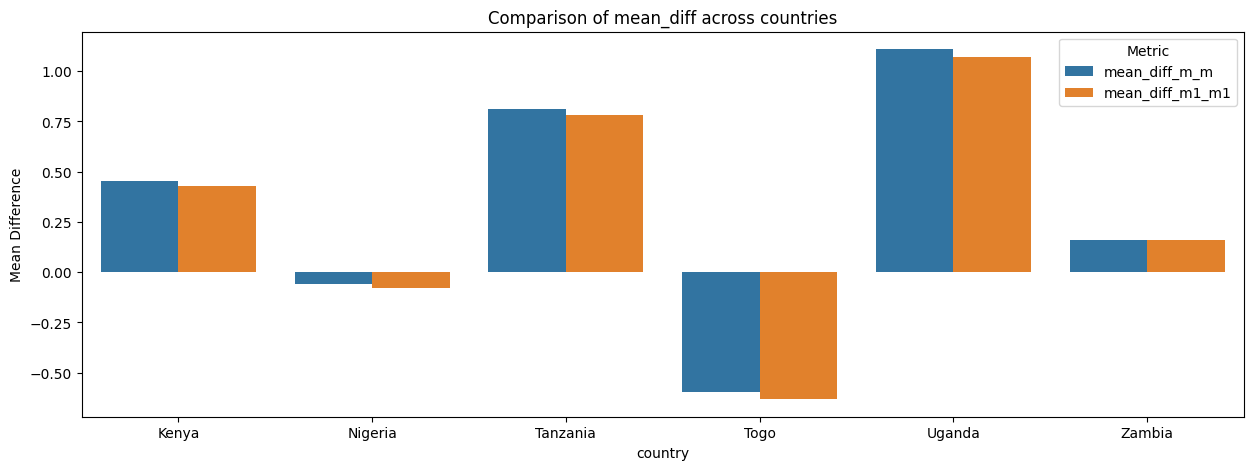

In [82]:
df_long = df_country.melt(id_vars="country", 
                  value_vars=["mean_diff_m_m", "mean_diff_m1_m1"], 
                  var_name="Metric", 
                  value_name="Value")

# Plot
plt.figure(figsize=(15,5))
sns.barplot(data=df_long, x="country", y="Value", hue="Metric")
plt.title("Comparison of mean_diff across countries")
plt.ylabel("Mean Difference")
plt.show()

In [83]:
df_product = pd.read_csv("data_country_and_product.csv")
df_product.columns = [i.replace(" ", "_").lower() for i in df_product.columns]
df_product

,date_uploaded_date,country,registration_date_month,product_group,predicted_frr_updated
0,2025-09-01,Kenya,2024-08,Lanterns,0.885024
1,2025-09-01,Kenya,2024-07,Lanterns,0.884609
2,2025-09-01,Kenya,2024-06,Lanterns,0.885571
3,2025-09-01,Kenya,2024-05,Lanterns,0.869871
4,2025-09-01,Kenya,2024-04,Lanterns,0.873007
...,...,...,...,...,...
3515,2025-10-02,Zambia,2022-11,SHS without TV,0.904128
3516,2025-10-02,Zambia,2022-10,SHS without TV,0.974020
3517,2025-10-02,Zambia,2022-09,SHS without TV,0.914416
3518,2025-10-02,Zambia,2022-08,SHS without TV,0.877309


In [84]:
df_product_pivot = df_product.pivot_table(values=["predicted_frr_updated"], 
               index=["country", "registration_date_month", "product_group"], 
               columns=["date_uploaded_date"], 
               aggfunc={"predicted_frr_updated": "mean"}).reset_index()
               
df_product_pivot.columns = ["_".join([str(i) for i in col if i]) for col in df_product_pivot.columns]  
df_product_pivot["diff_m_m"] = ((df_product_pivot["predicted_frr_updated_2025-10-02"] - df_product_pivot["predicted_frr_updated_2025-10-01"])*100).round(4) 
df_product_pivot.head()

,country,registration_date_month,product_group,predicted_frr_updated_2025-09-01,predicted_frr_updated_2025-09-02,predicted_frr_updated_2025-10-01,predicted_frr_updated_2025-10-02,diff_m_m
0,Kenya,2021-06,Lanterns,0.922012,0.923135,0.922006,0.923134,0.1128
1,Kenya,2021-06,Phones,0.923231,0.924663,0.923231,0.924663,0.1431
2,Kenya,2021-06,SHS Entry-Level,0.840099,0.846518,0.840106,0.846520,0.6414
3,Kenya,2021-06,SHS with TV,0.770173,0.773347,0.770352,0.773580,0.3228
4,Kenya,2021-07,Lanterns,0.922239,0.924197,0.922240,0.924197,0.1957


In [85]:
df_product_pivot.country.unique()

array(['Kenya', 'Nigeria', 'Tanzania', 'Togo', 'Uganda', 'Zambia'],
      dtype=object)

## Visuals per Country and Product Group

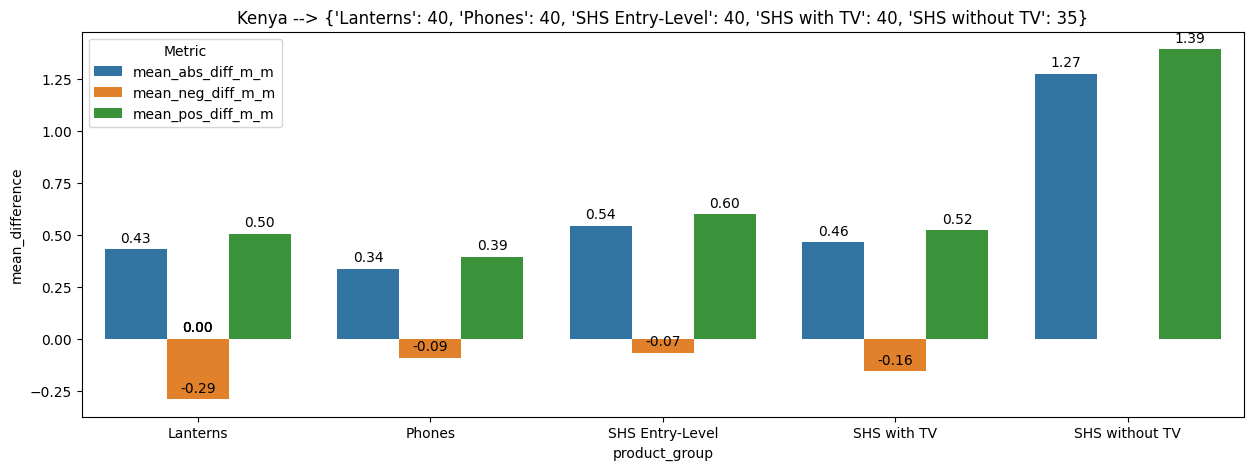

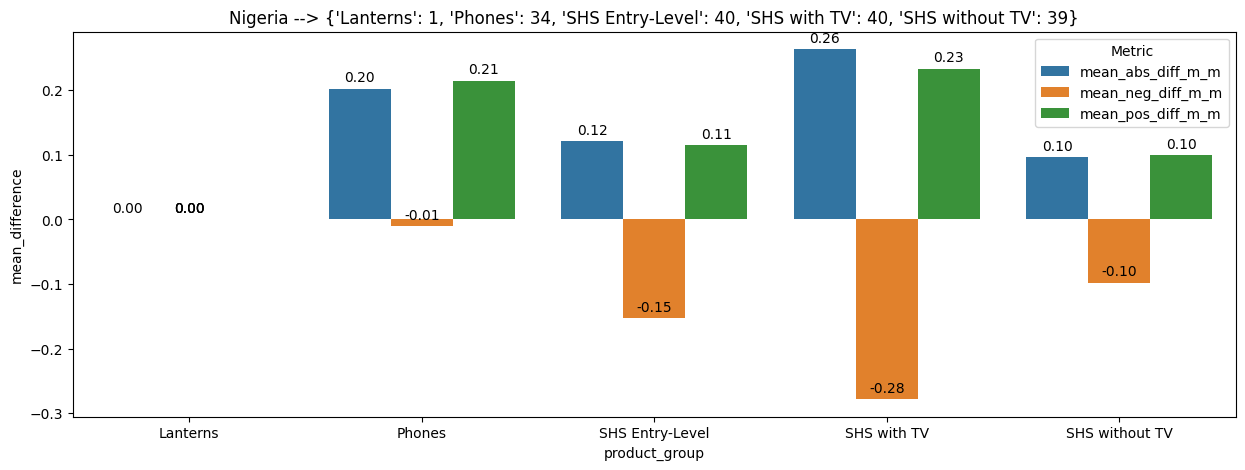

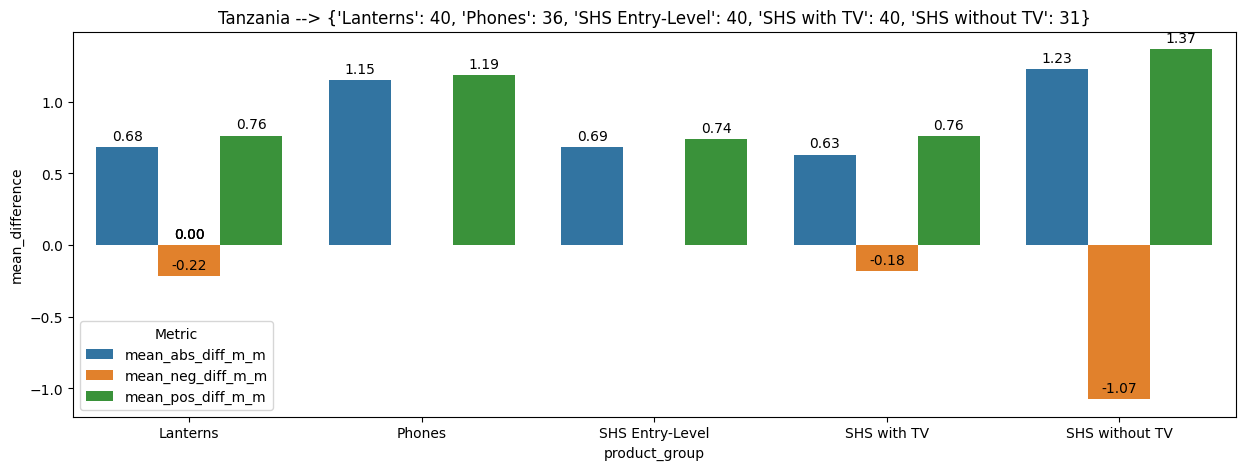

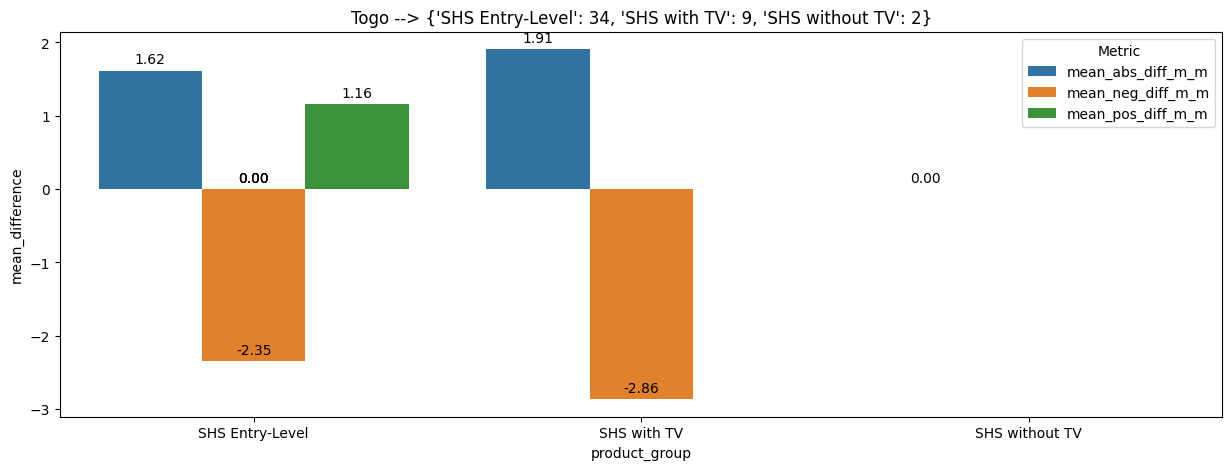

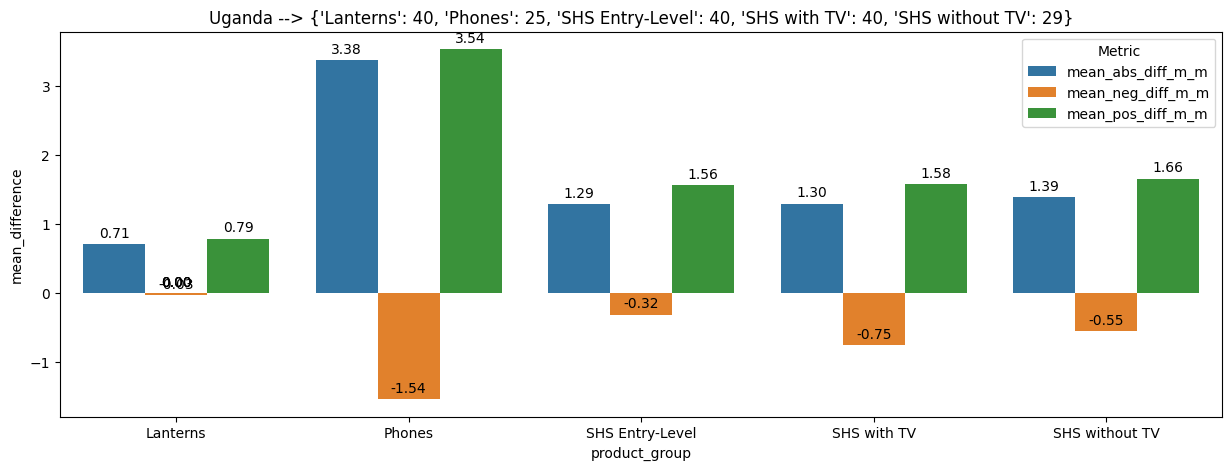

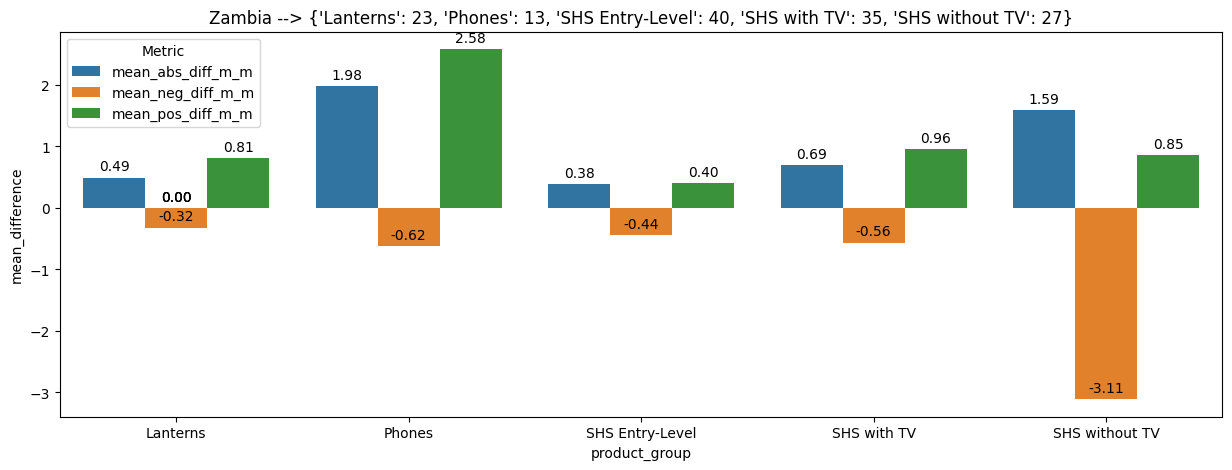

In [86]:
for country in df_product_pivot.country.unique():
    df_product = df_product_pivot[df_product_pivot.country==country].groupby("product_group").agg(
        mean_abs_diff_m_m=("diff_m_m", lambda x: np.mean(np.abs(x))),
        mean_neg_diff_m_m=("diff_m_m", lambda x: np.mean(x[x < 0]) if np.any(x < 0) else np.nan),
        mean_pos_diff_m_m=("diff_m_m", lambda x: np.mean(x[x > 0]) if np.any(x > 0) else np.nan),
        count_all=("diff_m_m", "count"),
        count_neg=("diff_m_m", lambda x: (x < 0).sum()),
        count_pos=("diff_m_m", lambda x: (x > 0).sum()),
    ).reset_index()

    df_long_product = df_product.melt(
        id_vars="product_group", 
        value_vars=["mean_abs_diff_m_m", "mean_neg_diff_m_m", "mean_pos_diff_m_m"], 
        var_name="Metric", 
        value_name="Value"
    )

    plt.figure(figsize=(15,5))
    ax = sns.barplot(data=df_long_product, x="product_group", y="Value", hue="Metric")

    plt.title(f"{country} --> {dict(zip(df_product["product_group"], df_product["count_all"]))}")
    plt.ylabel("mean_difference")

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), ".2f"), 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha="center", va="bottom",
            xytext=(0, 3), 
            textcoords="offset points"
        )

    plt.show()
